In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import collections
from pathlib import Path
from tqdm.auto import tqdm

import math
%pylab inline
%reload_ext autoreload
%autoreload 2


Populating the interactive namespace from numpy and matplotlib


/home/wassname/.pyenv/versions/3.7.2/envs/jup3.7.2/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger("smartmeters.ipynb")

In [3]:
import torch
from torch import nn
import torch.nn.functional as F

In [4]:
from src.models.model import LatentModel
from src.data.smart_meter import collate_fns, SmartMeterDataSet

In [5]:
# Params
device='cuda'
batch_size=32
num_workers=5
use_logy=False
num_context, num_extra_target = 24*2*3, 24*2
esp=1e-4

# Load kaggle smart meter data

In [6]:
csv_files = sorted(Path('data/smart-meters-in-london/halfhourly_dataset').glob('*.csv'))[:1]
df = pd.concat([pd.read_csv(f, parse_dates=[1], na_values=['Null']) for f in tqdm(csv_files)])
print(df.info())

df = df.groupby('tstp').mean()
df['tstp'] = df.index
df.index.name = ''
df.head(3)




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1222670 entries, 0 to 1222669
Data columns (total 3 columns):
LCLid             1222670 non-null object
tstp              1222670 non-null datetime64[ns]
energy(kWh/hh)    1222620 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 28.0+ MB
None


,energy(kWh/hh),tstp
,,
2011-12-03 09:00:00,0.149,2011-12-03 09:00:00
2011-12-03 09:30:00,0.154,2011-12-03 09:30:00
2011-12-03 10:00:00,0.768,2011-12-03 10:00:00


In [7]:
# Load weather data
df_weather = pd.read_csv('data/smart-meters-in-london/weather_hourly_darksky.csv', parse_dates=[3])

use_cols = ['visibility', 'windBearing', 'temperature', 'time', 'dewPoint',
       'pressure', 'apparentTemperature', 'windSpeed', 
       'humidity']
df_weather = df_weather[use_cols].set_index('time')

# Resample to match energy data    
df_weather = df_weather.resample('30T').ffill()

# Normalise
weather_norms=dict(mean={'visibility': 11.2,
 'windBearing': 195.7,
 'temperature': 10.5,
 'dewPoint': 6.5,
 'pressure': 1014.1,
 'apparentTemperature': 9.2,
 'windSpeed': 3.9,
 'humidity': 0.8},
std={'visibility': 3.1,
 'windBearing': 90.6,
 'temperature': 5.8,
 'dewPoint': 5.0,
 'pressure': 11.4,
 'apparentTemperature': 6.9,
 'windSpeed': 2.0,
 'humidity': 0.1})

for col in df_weather.columns:
    df_weather[col] -= weather_norms['mean'][col]
    df_weather[col] /= weather_norms['std'][col]

    
print(len(df))
df = pd.concat([df, df_weather], 1).dropna()
len(df)

39292


39225

In [8]:
# Also find bank holidays
df_hols = pd.read_csv('./data/smart-meters-in-london/uk_bank_holidays.csv', parse_dates=[0])
holidays = set(df_hols['Bank holidays'].dt.round('D'))

df['holiday'] = df.tstp.apply(lambda dt:dt.floor('D') in holidays).astype(int)

In [9]:
# Add time features
time = df.tstp
df["month"] = time.dt.month / 12.0
df['day'] = time.dt.day / 310.0
df['week'] = time.dt.week / 52.0
df['hour'] = time.dt.hour / 24.0
df['minute'] = time.dt.minute / 24.0
df['dayofweek'] = time.dt.dayofweek / 7.0

In [10]:
# Drop nan and 0's
df = df[df['energy(kWh/hh)']!=0]
df = df.dropna()

if use_logy:
    df['energy(kWh/hh)'] = np.log(df['energy(kWh/hh)']+eps)
df = df.sort_values('tstp')
df.describe()

,energy(kWh/hh),visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,holiday,month,day,week,hour,minute,dayofweek
count,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000
mean,0.449333,0.029285,0.018890,0.005533,0.009592,-0.010061,0.010214,0.013695,-0.202741,0.021976,0.529373,0.050786,0.495566,0.479369,0.624984,0.428291
std,0.218992,0.959951,1.002480,1.021497,1.030993,1.005238,1.030426,1.020799,1.401747,0.146606,0.306145,0.028288,0.307568,0.288379,0.625008,0.285822
min,0.023000,-3.525806,-2.160044,-2.782759,-3.296000,-3.364912,-2.620290,-1.930000,-5.700000,0.000000,0.083333,0.003226,0.019231,0.000000,0.000000,0.000000
25%,0.293000,-0.270968,-0.758278,-0.706897,-0.756000,-0.594737,-0.791304,-0.740000,-1.000000,0.000000,0.250000,0.025806,0.211538,0.250000,0.000000,0.142857
50%,0.436444,0.358065,0.257174,-0.089655,0.022000,0.034211,0.078261,-0.095000,0.100000,0.000000,0.500000,0.051613,0.480769,0.500000,0.000000,0.428571
75%,0.583932,0.606452,0.676600,0.712069,0.794000,0.680702,0.786957,0.605000,0.900000,0.000000,0.833333,0.074194,0.769231,0.750000,1.250000,0.714286
max,1.981000,1.577419,1.802428,3.775862,2.676000,2.563158,3.365217,5.450000,2.000000,1.000000,1.000000,0.100000,1.000000,0.958333,1.250000,0.857143


In [11]:
# split data
n_split = -int(len(df)*0.1)
df_train = df[:n_split]
df_test = df[n_split:]
len(df_train), len(df_test)

(35303, 3922)

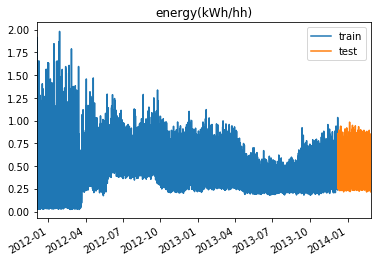

In [12]:
df_train['energy(kWh/hh)'].plot(label='train')
df_test['energy(kWh/hh)'].plot(label='test')
plt.title('energy(kWh/hh)')
plt.legend()

# Plot helpers

In [13]:
def plot_functions(target_x, target_y, context_x, context_y, pred_y, std, undo_log=use_logy, legend=False):
    """Plots the predicted mean and variance and the context points.
  
  Args: 
    target_x: An array of shape [B,num_targets,1] that contains the
        x values of the target points.
    target_y: An array of shape [B,num_targets,1] that contains the
        y values of the target points.
    context_x: An array of shape [B,num_contexts,1] that contains 
        the x values of the context points.
    context_y: An array of shape [B,num_contexts,1] that contains 
        the y values of the context points.
    pred_y: An array of shape [B,num_targets,1] that contains the
        predicted means of the y values at the target points in target_x.
    std: An array of shape [B,num_targets,1] that contains the
        predicted std dev of the y values at the target points in target_x.
      """
    if undo_log:
        target_y=np.exp(target_y)-eps
        context_y=np.exp(context_y)-eps
    # Plot everything 
    # Note: days is first feature in x, since we made sure of that in the dataloader)
    j=0
    
    plt.plot(target_x[0,:,j], target_y[0], 'k:', linewidth=2, label='true')
    plt.plot(context_x[0,:,j], context_y[0], 'ko', markersize=6, label='input data')
    ylims=plt.ylim()
    plt.plot(target_x[0,:,j], pred_y[0], 'b', linewidth=2, label='predicted')
    plt.fill_between(
          target_x[0, :, j],
          pred_y[0, :, 0] - std[0, :, 0],
          pred_y[0, :, 0] + std[0, :, 0],
          alpha=0.25,
          facecolor='blue',
          interpolate=True,
    label='uncertainty')

    # Make the plot pretty
    plt.grid('off')
    plt.ylim(*ylims)
    plt.xlabel('Days')
    plt.ylabel('Energy (kWh/hh)')
    plt.grid(b=None)
    if legend:
        plt.legend()
    ax = plt.gca()
    plt.show()

In [14]:
def plot_from_loader(loader, i=0, undo_log=use_logy, title='', plot=True, legend=False):
    data = loader.collate_fn([loader.dataset[i]])
    data = [d.to(device) for d in data]
    context_x, context_y, target_x, target_y = data

    model.eval()
    with torch.no_grad():
        y_pred, kl, loss_test, y_std = model(context_x, context_y, target_x, target_y)

        if plot:
            plt.title(title+f" loss={loss_test: 2.2g}")
            plot_functions(target_x.detach().cpu().numpy(),
                            target_y.detach().cpu().numpy(),
                            context_x.detach().cpu().numpy(),
                            context_y.detach().cpu().numpy(),
                            y_pred.detach().cpu().numpy(),
                            y_std.detach().cpu().numpy(), undo_log=undo_log, legend=legend)
    return loss_test

# Dataloaders

In [15]:
data_train = SmartMeterDataSet(df_train, num_context, num_extra_target)
data_test = SmartMeterDataSet(df_test, num_context, num_extra_target)

In [16]:
loader_train = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True, 
    collate_fn=collate_fns(num_context, num_extra_target, sample=True),
    num_workers=num_workers,
)

loader_test = torch.utils.data.DataLoader(data_test, batch_size=batch_size, shuffle=False, 
    collate_fn=collate_fns(num_context, num_extra_target, sample=False)
)

# Run

In [17]:
x, y, _, _ = next(iter(loader_train))
x.shape, y.shape

(torch.Size([32, 31, 16]), torch.Size([32, 31, 1]))

In [18]:
from torch import nn
import torch.nn.functional as F

class CausalConv1d(nn.Conv1d):
    """
    CausalConv1d which only pads on the left.

    See: https://github.com/iwasaki-kenta/keita/blob/master/layers/convolution.py#L40
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 dilation=1,
                 groups=1,
                 bias=True):
        super(CausalConv1d, self).__init__(
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding=0,
            dilation=dilation,
            groups=groups,
            bias=bias)

        self.left_padding = dilation * (kernel_size - 1)

    def forward(self, input):
        x = F.pad(input.unsqueeze(2), (self.left_padding, 0, 0, 0)).squeeze(2)

        return super(CausalConv1d, self).forward(x)


In [19]:


class NPBlockRelu2d(nn.Module):
    """Block for Neural Processes."""

    def __init__(self, in_channels, out_channels, dropout=0, norm=True):
        super().__init__()
        self.linear = nn.Linear(in_channels, out_channels)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout2d(dropout)
        self.norm = nn.BatchNorm2d(out_channels) if norm else False

    def forward(self, x):
        # x.shape is (Batch, Sequence, Channels)
        # We pass a linear over it which operates on the Channels
        x = self.act(self.linear(x))

        # Now we want to apply batchnorm and dropout to the channels. So we put it in shape
        # (Batch, Channels, Sequence, None) so we can use Dropout2d
        x = x.permute(0, 2, 1)[:, :, :, None]

        if self.norm:
            x = self.norm(x)

        x = self.dropout(x)
        return x[:, :, :, 0].permute(0, 2, 1)


def block_relu(in_dim, out_dim, dropout=0, inplace=False):
    return nn.Sequential(
        nn.Linear(in_dim, out_dim),
        nn.ReLU(inplace=inplace),
        nn.BatchNorm1d(out_dim),
        nn.Dropout(dropout, inplace=inplace),
    )


class Attention(nn.Module):
    def __init__(self, hidden_dim, attention_type, n_heads=8, dropout=0):
        super().__init__()
        if attention_type == "uniform":
            self._attention_func = self._uniform_attention
        elif attention_type == "laplace":
            self._attention_func = self._laplace_attention
        elif attention_type == "dot":
            self._attention_func = self._dot_attention
        elif attention_type == "multihead":
            self._mattn = torch.nn.MultiheadAttention(
                hidden_dim, n_heads, bias=False, dropout=dropout
            )
            self._attention_func = self._pytorch_multihead_attention
            self.n_heads = n_heads
        else:
            raise NotImplementedError

    def forward(self, k, v, q):
        rep = self._attention_func(k, v, q)
        return rep

    def _uniform_attention(self, k, v, q):
        total_points = q.shape[1]
        rep = torch.mean(v, dim=1, keepdim=True)
        rep = rep.repeat(1, total_points, 1)
        return rep

    def _laplace_attention(self, k, v, q, scale=0.5):
        k_ = k.unsqueeze(1)
        v_ = v.unsqueeze(2)
        unnorm_weights = torch.abs((k_ - v_) * scale)
        unnorm_weights = unnorm_weights.sum(dim=-1)
        weights = torch.softmax(unnorm_weights, dim=-1)
        rep = torch.einsum("bik,bkj->bij", weights, v)
        return rep

    def _dot_attention(self, k, v, q):
        scale = q.shape[-1] ** 0.5
        unnorm_weights = torch.einsum("bjk,bik->bij", k, q) / scale
        weights = torch.softmax(unnorm_weights, dim=-1)

        rep = torch.einsum("bik,bkj->bij", weights, v)
        return rep

    def _pytorch_multihead_attention(self, k, v, q):
        # Pytorch multiheaded attention takes inputs if diff order and permutation
        o = self._mattn(q.permute(1, 0, 2), k.permute(1, 0, 2), v.permute(1, 0, 2))[0]
        return o.permute(1, 0, 2)


    
class LatentEncoder(nn.Module):
    """
    Latent Encoder [For prior, posterior]
    """
    def __init__(
        self,
        input_dim,
        hidden_dim=32,
        latent_dim=32,
        n_heads=4,
        self_attention_type="multihead",
        n_encoder_layers=3,
        dropout=0,
        attention_dropout=0,
    ):
        super().__init__()
        self._input_layer = NPBlockRelu2d(input_dim, hidden_dim, dropout)
        self._encoder = nn.Sequential(
            *[
                NPBlockRelu2d(hidden_dim, hidden_dim, dropout)
                for _ in range(n_encoder_layers)
            ]
        )
        self._self_attention = Attention(
            hidden_dim, self_attention_type, n_heads=n_heads, dropout=attention_dropout
        )
        self._penultimate_layer = block_relu(hidden_dim, hidden_dim, dropout)
        self._mean = nn.Linear(hidden_dim, latent_dim)
        self._log_var = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x, y):
        """Encodes the inputs into one representation.

        Args:
        x: Tensor of shape [B,observations,d_x]. For this 1D regression
            task this corresponds to the x-values.
        y: Tensor of shape [B,observations,d_y]. For this 1D regression
            task this corresponds to the y-values.

        Returns:
        - A normal distribution over tensors of shape [B, num_latents]
        - log_var
        """
        # Concat location (x) and value (y) along the filter axes
        encoder_input = torch.cat([x, y], dim=-1)

        # Pass final axis through MLP
        encoded = self._input_layer(encoder_input)
        encoded = self._encoder(encoded)

        # Self-attention aggregator
        attention_output = self._self_attention(encoded, encoded, encoded)
        mean_repr = attention_output.mean(dim=1)

        # Have further MLP layers
        mean_repr = self._penultimate_layer(mean_repr)

        return mean_repr

In [20]:
def causalconv1d_relu_block(in_channels, out_channels, dropout=0, **kwargs):
    """This breaks docstrings, but saves code."""
    return nn.Sequential(
        CausalConv1d(in_channels, out_channels, **kwargs),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(out_channels),
        nn.Dropout(dropout),
    )

def relu_block(in_channels, out_channels, dropout=0, **kwargs):
    """This breaks docstrings, but saves code."""
    return nn.Sequential(
        nn.Linear(in_channels, out_channels, **kwargs),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(out_channels),
        nn.Dropout(dropout),
    )



class LSTM1d(nn.Module):
    """Simple LSTM model to predict seq of y given seq of x."""
    def __init__(self, channels, num_outputs, lstm_channels=32, head_features=32, attention_dropout=0, dropout=0, lstm_layers=2, bidirectional=False):
        super().__init__()
        self.num_outputs = num_outputs
        encoder_channels = lstm_channels
        
        
        self.encoder = LatentEncoder(
            channels + num_outputs,
            hidden_dim=encoder_channels,
            latent_dim=encoder_channels,
            dropout=dropout,
            attention_dropout=attention_dropout,
#             n_heads=num_heads,
        )
        self.pre_lstm = nn.Sequential(
            # 1x1 to reduce channels
            causalconv1d_relu_block(channels + num_outputs, lstm_channels, kernel_size=1, dropout=dropout,)
        )
        self.lstm = nn.Sequential(
            nn.LSTM(
                lstm_channels,
                lstm_channels,
                num_layers=lstm_layers,
                bidirectional=bidirectional,
                batch_first=True,
                dropout=dropout,
            ),

        )
        
        # head to reduce features
        self.output = nn.Sequential(
            nn.LSTM(
                lstm_channels,
                num_outputs*2,
                num_layers=1,
                bidirectional=False,
                batch_first=True,
                dropout=dropout,
            )
        )
    
    def forward(self, context_x, context_y, target_x, target_y=None):
        # Add the previous labels on to the input, pad with zero for future
        xy = torch.zeros_like(target_x)[:, :, :self.num_outputs]
        xy[:, :context_x.shape[1], :] = context_y
        x = torch.cat([target_x, xy], -1).permute([0, 2, 1])

        # conv1x1, lstm, head
        data = self.pre_lstm(x).permute([0, 2, 1])
        data = self.lstm(data)[0]#[:, -1]
        target_y_pred = self.output(data)[0]
        
        loc=target_y_pred[:, :, :self.num_outputs]
        log_scale=target_y_pred[:, :, self.num_outputs:] + math.log(0.1)
        scale = log_scale.exp()
        
        dist = torch.distributions.Normal(
            loc=loc, scale=scale)
        
        if target_y is not None:
            loss = - dist.log_prob(target_y).mean()
        else:
            loss = None
            
        y_pred = dist.rsample() if self.training else dist.loc
            
        return y_pred, torch.Tensor([0]), loss, dist.scale

In [21]:
from src.models.model import LatentModel
model = LSTM1d(
    x.shape[-1],
    y.shape[-1],
    lstm_channels=64,
    head_features=64,
    attention_dropout=0.5,
    dropout=0.5,
    lstm_layers=3, ).cuda()

optim = torch.optim.AdamW(model.parameters(), lr=1e-4)

/home/wassname/.pyenv/versions/3.7.2/envs/jup3.7.2/lib/python3.7/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [22]:
from torchsummaryX import summary
data = next(iter(loader_train))
data = [d.to(device) for d in data]
context_x, context_y, target_x, target_y = data
with torch.no_grad():
    model.eval()
    summary(model, context_x, context_y, target_x, target_y)
    dist, log_p, kl, loss = model(context_x, context_y, target_x, target_y)

                            Kernel Shape  Output Shape  Params Mult-Adds
Layer                                                                   
0_pre_lstm.0.CausalConv1d_0  [17, 64, 1]  [32, 64, 57]  1.152k   62.016k
1_pre_lstm.0.ReLU_1                    -  [32, 64, 57]       -         -
2_pre_lstm.0.BatchNorm1d_2          [64]  [32, 64, 57]   128.0      64.0
3_pre_lstm.0.Dropout_3                 -  [32, 64, 57]       -         -
4_lstm.LSTM_0                          -  [32, 57, 64]  99.84k   98.304k
5_output.LSTM_0                        -   [32, 57, 2]   544.0     528.0
--------------------------------------------------------------------------
                        Totals
Total params          101.664k
Trainable params      101.664k
Non-trainable params       0.0
Mult-Adds             160.912k


In [23]:

import gc
gc.collect()
torch.cuda.empty_cache()

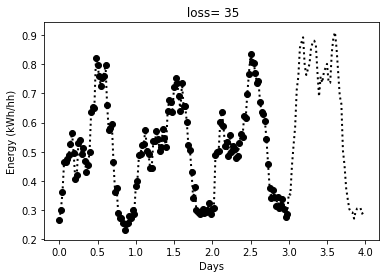

tensor(34.5707, device='cuda:0')

In [24]:
# Lets choose a challenging time to forecast
vis_i = 670 # 290 # 1600
plot_from_loader(loader_test, i=vis_i)

0, i=0, loss: 25.7, test: 33.52, grad_norm:  1.5e+02, std:  0.069
0, i=100, loss: 0.9625, test: 0.1118, grad_norm:  2.7, std:  0.1
0, i=200, loss: -0.01935, test: -0.2858, grad_norm:  1, std:  0.15
0, i=300, loss: -0.04047, test: -0.2572, grad_norm:  0.47, std:  0.21
0, i=400, loss: -0.1627, test: -0.2628, grad_norm:  0.46, std:  0.21
0, i=500, loss: -0.05236, test: -0.2822, grad_norm:  0.82, std:  0.2
0, i=600, loss: -0.007392, test: -0.2954, grad_norm:  0.54, std:  0.2
0, i=700, loss: -0.1697, test: -0.3302, grad_norm:  0.87, std:  0.2
0, i=800, loss: -0.262, test: -0.3567, grad_norm:  0.58, std:  0.19
0, i=900, loss: -0.1492, test: -0.378, grad_norm:  2.1, std:  0.18
0, i=1000, loss: -0.246, test: -0.3831, grad_norm:  0.66, std:  0.19


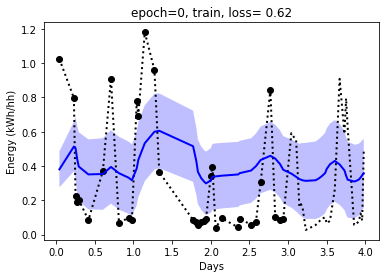

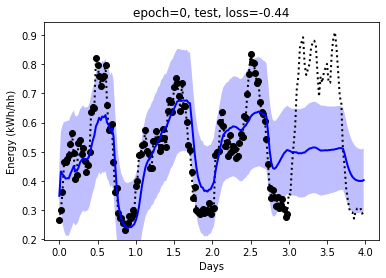

epoch: 0, loss: -0.4049, loss_test:-0.4419, kl= 0, grad_norm:  1.2


1, i=0, loss: -0.3808, test: -0.4414, grad_norm:  0.64, std:  0.18
1, i=100, loss: -0.1919, test: -0.4864, grad_norm:  1.2, std:  0.17
1, i=200, loss: -0.4065, test: -0.5414, grad_norm:  0.86, std:  0.16
1, i=300, loss: -0.4078, test: -0.5929, grad_norm:  1.1, std:  0.16
1, i=400, loss: -0.2929, test: -0.6567, grad_norm:  1.9, std:  0.15
1, i=500, loss: -0.5043, test: -0.6412, grad_norm:  1.8, std:  0.16
1, i=600, loss: -0.2816, test: -0.6916, grad_norm:  2, std:  0.15
1, i=700, loss: -0.3607, test: -0.7421, grad_norm:  4.1, std:  0.14
1, i=800, loss: -0.2206, test: -0.7639, grad_norm:  2.7, std:  0.14
1, i=900, loss: -0.1705, test: -0.7724, grad_norm:  3.9, std:  0.14
1, i=1000, loss: -0.5863, test: -0.728, grad_norm:  2.6, std:  0.15


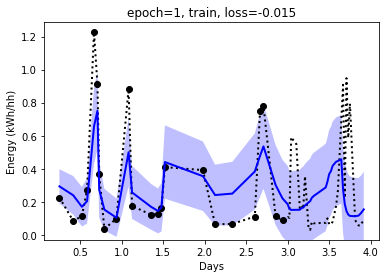

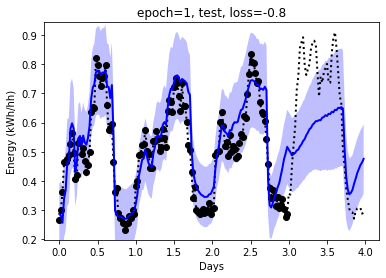

epoch: 1, loss: -0.6676, loss_test:-0.8041, kl= 0, grad_norm:  3.2


2, i=0, loss: -0.6966, test: -0.8113, grad_norm:  0.75, std:  0.14
2, i=100, loss: -0.6018, test: -0.8023, grad_norm:  3.6, std:  0.15
2, i=200, loss: -0.7142, test: -0.844, grad_norm:  2.9, std:  0.13
2, i=300, loss: -0.6727, test: -0.8548, grad_norm:  1.3, std:  0.13
2, i=400, loss: -0.7153, test: -0.8538, grad_norm:  1.2, std:  0.12
2, i=500, loss: -0.4034, test: -0.8658, grad_norm:  2.1, std:  0.13
2, i=600, loss: -0.7483, test: -0.8483, grad_norm:  1.8, std:  0.12
2, i=700, loss: -0.6353, test: -0.838, grad_norm:  1.1, std:  0.14
2, i=800, loss: -0.2898, test: -0.8411, grad_norm:  2.6, std:  0.14
2, i=900, loss: -0.6593, test: -0.879, grad_norm:  2.1, std:  0.13
2, i=1000, loss: -0.7843, test: -0.9194, grad_norm:  0.67, std:  0.13


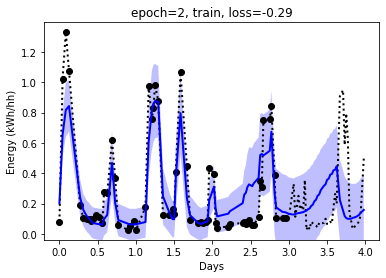

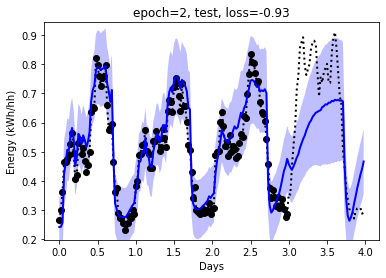

epoch: 2, loss: -0.8085, loss_test:-0.9317, kl= 0, grad_norm:  1.1


3, i=0, loss: -0.6469, test: -0.9281, grad_norm:  1.5, std:  0.12
3, i=100, loss: -0.4948, test: -0.9327, grad_norm:  1.6, std:  0.12
3, i=200, loss: -0.6311, test: -0.9751, grad_norm:  2.2, std:  0.13
3, i=300, loss: -0.7663, test: -0.9942, grad_norm:  0.96, std:  0.13
3, i=400, loss: -0.6558, test: -0.9677, grad_norm:  0.97, std:  0.13
3, i=500, loss: -0.8359, test: -0.9381, grad_norm:  0.71, std:  0.13
3, i=600, loss: -0.5545, test: -0.9873, grad_norm:  3.1, std:  0.15
3, i=700, loss: -0.763, test: -1.017, grad_norm:  1.2, std:  0.13
3, i=800, loss: -0.8715, test: -0.9954, grad_norm:  0.93, std:  0.13
3, i=900, loss: -0.4153, test: -0.9649, grad_norm:  3.4, std:  0.13
3, i=1000, loss: -0.8821, test: -0.9679, grad_norm:  1.1, std:  0.12


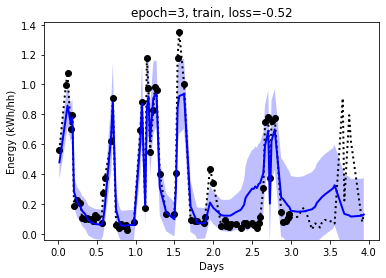

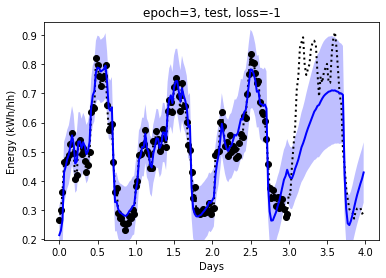

epoch: 3, loss: -0.8557, loss_test:-1.004, kl= 0, grad_norm:  3.6


4, i=0, loss: -0.8966, test: -1.006, grad_norm:  0.64, std:  0.12
4, i=100, loss: -0.8547, test: -0.9908, grad_norm:  0.57, std:  0.13
4, i=200, loss: -0.7294, test: -1.03, grad_norm:  2.2, std:  0.12
4, i=300, loss: -0.8763, test: -1.048, grad_norm:  0.78, std:  0.12
4, i=400, loss: -0.6897, test: -0.9921, grad_norm:  2.8, std:  0.12
4, i=500, loss: -0.9932, test: -0.9943, grad_norm:  1.4, std:  0.11
4, i=600, loss: -0.9497, test: -1.03, grad_norm:  2.4, std:  0.11
4, i=700, loss: -0.8783, test: -1.069, grad_norm:  2, std:  0.12
4, i=800, loss: -0.9066, test: -1.032, grad_norm:  2, std:  0.13
4, i=900, loss: -0.9674, test: -1.005, grad_norm:  1.1, std:  0.11
4, i=1000, loss: -0.4635, test: -0.9885, grad_norm:  1.2, std:  0.14


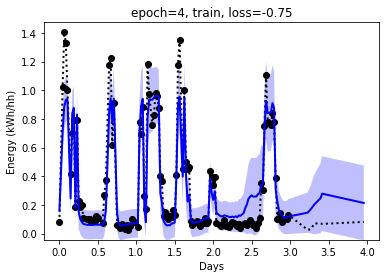

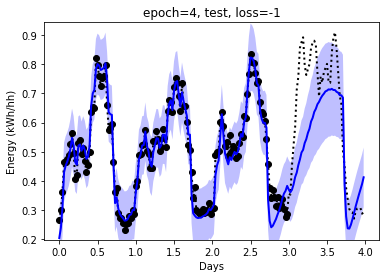

epoch: 4, loss: -0.392, loss_test:-1.011, kl= 0, grad_norm:  6.1


5, i=0, loss: -0.8842, test: -1.012, grad_norm:  2.6, std:  0.11
5, i=100, loss: -0.7843, test: -0.9442, grad_norm:  1.7, std:  0.12
5, i=200, loss: -0.9278, test: -1.007, grad_norm:  0.61, std:  0.11
5, i=300, loss: -0.9503, test: -1.031, grad_norm:  0.94, std:  0.12
5, i=400, loss: -0.9745, test: -1.038, grad_norm:  1.3, std:  0.12
5, i=500, loss: -0.9761, test: -1.038, grad_norm:  2, std:  0.12
5, i=600, loss: -0.9822, test: -1.057, grad_norm:  0.87, std:  0.12
5, i=700, loss: -1.012, test: -1.005, grad_norm:  0.87, std:  0.11
5, i=800, loss: -0.7146, test: -1.043, grad_norm:  2.2, std:  0.13
5, i=900, loss: -0.9463, test: -1.007, grad_norm:  0.96, std:  0.12
5, i=1000, loss: -1.013, test: -0.947, grad_norm:  1.4, std:  0.11


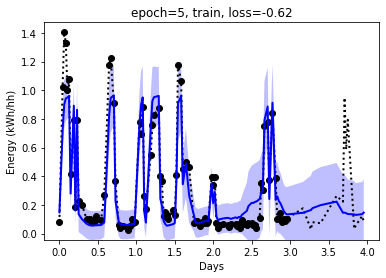

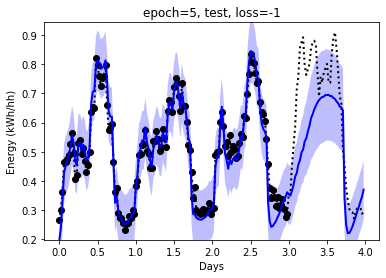

epoch: 5, loss: -1.054, loss_test:-1.021, kl= 0, grad_norm:  2.1


6, i=0, loss: -1.067, test: -1.01, grad_norm:  0.66, std:  0.11
6, i=100, loss: -1.021, test: -0.9794, grad_norm:  0.76, std:  0.11
6, i=200, loss: -0.9423, test: -1.013, grad_norm:  0.54, std:  0.12
6, i=300, loss: -1.049, test: -1.034, grad_norm:  0.79, std:  0.11
6, i=400, loss: -0.8667, test: -1.072, grad_norm:  1.2, std:  0.12
6, i=500, loss: -0.9688, test: -0.9967, grad_norm:  1.2, std:  0.12
6, i=600, loss: -0.9558, test: -1.056, grad_norm:  1.8, std:  0.12
6, i=700, loss: -1.141, test: -1.026, grad_norm:  0.65, std:  0.11
6, i=800, loss: -0.676, test: -0.9358, grad_norm:  2.7, std:  0.12
6, i=900, loss: -0.8986, test: -0.97, grad_norm:  1.4, std:  0.13
6, i=1000, loss: -0.8636, test: -1.019, grad_norm:  0.91, std:  0.12


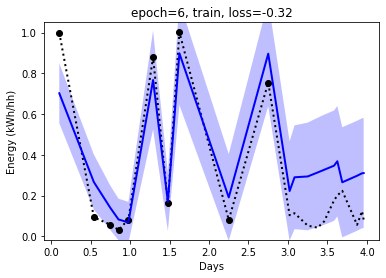

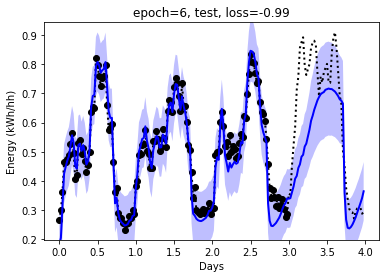

epoch: 6, loss: -1.105, loss_test:-0.9908, kl= 0, grad_norm:  2.2


7, i=0, loss: -1.05, test: -0.993, grad_norm:  0.66, std:  0.11
7, i=100, loss: -0.6191, test: -1.016, grad_norm:  1.6, std:  0.13
7, i=200, loss: -0.6912, test: -0.9389, grad_norm:  2.1, std:  0.12
7, i=300, loss: -1.044, test: -1.026, grad_norm:  2.8, std:  0.11
7, i=400, loss: -1.032, test: -0.9966, grad_norm:  2.4, std:  0.11
7, i=500, loss: -0.9995, test: -0.9603, grad_norm:  0.74, std:  0.11
7, i=600, loss: -1.026, test: -0.934, grad_norm:  0.61, std:  0.11
7, i=700, loss: -1.036, test: -0.9406, grad_norm:  0.48, std:  0.11
7, i=800, loss: -1.045, test: -0.9247, grad_norm:  0.5, std:  0.12
7, i=900, loss:   -1, test: -0.9953, grad_norm:  0.85, std:  0.12
7, i=1000, loss: -0.9781, test: -0.984, grad_norm:  1.3, std:  0.11


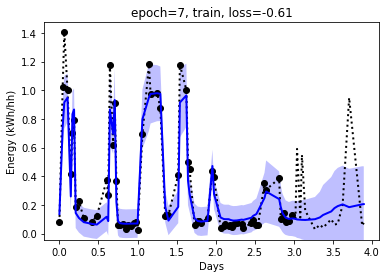

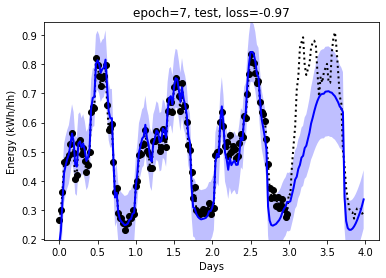

epoch: 7, loss: -0.786, loss_test:-0.9745, kl= 0, grad_norm:  2.5


8, i=0, loss: -1.049, test: -0.9803, grad_norm:  1.1, std:  0.11
8, i=100, loss: -1.187, test: -1.011, grad_norm:  0.89, std:  0.1
8, i=200, loss: -1.04, test: -0.9611, grad_norm:  0.63, std:  0.12
8, i=300, loss: -1.141, test: -0.9841, grad_norm:  0.5, std:  0.11
8, i=400, loss: -1.128, test: -0.9985, grad_norm:  0.65, std:  0.11
8, i=500, loss: -0.854, test: -0.9687, grad_norm:  2.1, std:  0.12
8, i=600, loss: -1.127, test: -0.9552, grad_norm:  0.48, std:  0.11
8, i=700, loss: -0.9031, test: -0.9696, grad_norm:  1.8, std:  0.11
8, i=800, loss: -1.086, test: -1.004, grad_norm:  1, std:  0.11
8, i=900, loss: -1.043, test: -0.9828, grad_norm:  1.6, std:  0.11
8, i=1000, loss: -1.004, test: -0.998, grad_norm:  1.5, std:  0.12


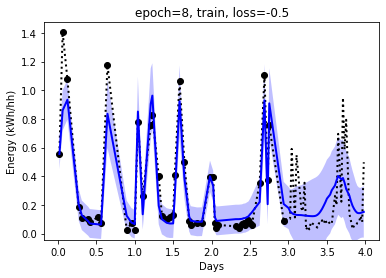

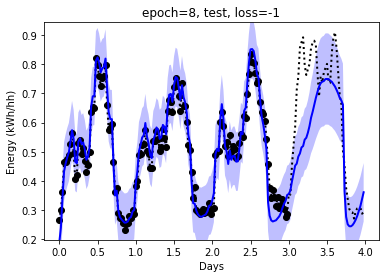

epoch: 8, loss: -0.9551, loss_test:-1.049, kl= 0, grad_norm:  3.5


9, i=0, loss: -1.044, test: -1.044, grad_norm:  1.2, std:  0.11
9, i=100, loss: -0.9958, test: -1.001, grad_norm:  1.2, std:  0.11
9, i=200, loss: -0.7612, test: -0.9511, grad_norm:  1.5, std:  0.13
9, i=300, loss: -1.092, test: -1.025, grad_norm:  1.3, std:  0.11
9, i=400, loss: -1.046, test: -0.9864, grad_norm:  0.82, std:  0.11
9, i=500, loss: -1.13, test: -1.039, grad_norm:  0.59, std:  0.11
9, i=600, loss: -1.069, test: -0.9995, grad_norm:  0.65, std:  0.11
9, i=700, loss: -0.9976, test: -0.9529, grad_norm:  1, std:  0.12
9, i=800, loss: -1.097, test: -1.029, grad_norm:  0.65, std:  0.11
9, i=900, loss: -0.8794, test: -1.03, grad_norm:  1.4, std:  0.12
9, i=1000, loss: -0.9662, test: -0.9703, grad_norm:  1, std:  0.12


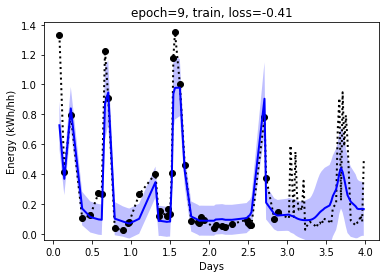

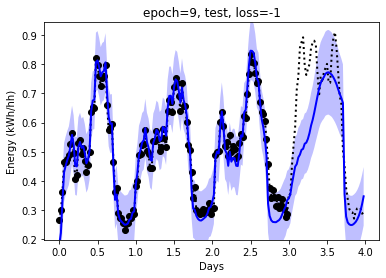

epoch: 9, loss: -1.079, loss_test:-1.029, kl= 0, grad_norm:  1.2


10, i=0, loss: -0.9963, test: -1.027, grad_norm:  1.5, std:  0.11
10, i=100, loss: -0.7539, test: -0.9303, grad_norm:  1.4, std:  0.13
10, i=200, loss: -1.143, test: -0.9833, grad_norm:  0.75, std:  0.11
10, i=300, loss: -1.033, test: -0.9776, grad_norm:  0.58, std:  0.11
10, i=400, loss: -1.087, test: -0.9571, grad_norm:  0.48, std:  0.11
10, i=500, loss: -1.01, test: -1.019, grad_norm:  1.6, std:  0.11
10, i=600, loss: -1.184, test: -0.9704, grad_norm:  0.87, std:  0.11
10, i=700, loss: -1.028, test: -1.006, grad_norm:  1.4, std:  0.11
10, i=800, loss: -0.8923, test: -1.033, grad_norm:  1.9, std:  0.12
10, i=900, loss: -1.163, test: -0.9917, grad_norm:  0.54, std:  0.1
10, i=1000, loss: -1.065, test: -0.9591, grad_norm:  1.9, std:  0.11


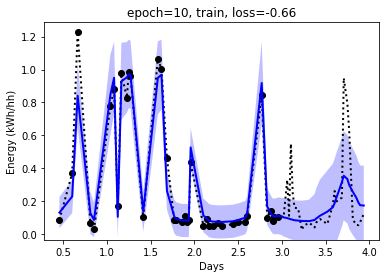

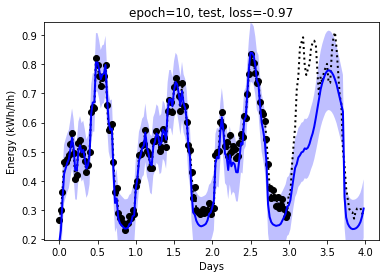

epoch: 10, loss: -1.152, loss_test:-0.971, kl= 0, grad_norm:  0.92


11, i=0, loss: -0.9541, test: -0.9561, grad_norm:  1.1, std:  0.12
11, i=100, loss: -1.073, test: -0.9779, grad_norm:  1.4, std:  0.11
11, i=200, loss: -0.7743, test: -0.9588, grad_norm:  1.4, std:  0.12
11, i=300, loss: -1.064, test: -1.051, grad_norm:  0.55, std:  0.11
11, i=400, loss: -1.054, test: -1.011, grad_norm:  1.2, std:  0.11
11, i=500, loss: -0.9758, test: -0.8945, grad_norm:  0.75, std:  0.12
11, i=600, loss: -0.9429, test: -0.9577, grad_norm:  1.1, std:  0.12
11, i=700, loss: -1.078, test: -1.018, grad_norm:  0.81, std:  0.11
11, i=800, loss: -1.106, test: -0.9351, grad_norm:  1.4, std:  0.11
11, i=900, loss: -1.046, test: -0.9738, grad_norm:  0.74, std:  0.11
11, i=1000, loss: -1.068, test: -1.041, grad_norm:  0.61, std:  0.11


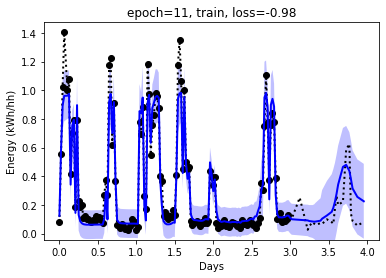

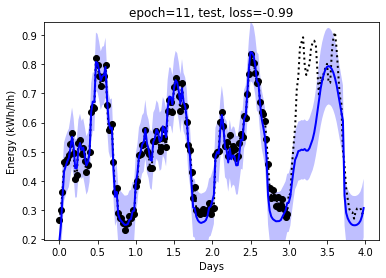

epoch: 11, loss: -0.8475, loss_test:-0.9946, kl= 0, grad_norm:  2.3


12, i=0, loss: -1.119, test: -1.01, grad_norm:  0.74, std:  0.11
12, i=100, loss: -1.113, test: -1.001, grad_norm:  0.65, std:  0.11
12, i=200, loss: -1.045, test: -1.006, grad_norm:  0.71, std:  0.11
12, i=300, loss: -1.08, test: -1.062, grad_norm:  1.6, std:  0.11
12, i=400, loss: -1.087, test: -0.9773, grad_norm:  0.99, std:  0.11
12, i=500, loss: -1.058, test: -0.9135, grad_norm:  0.85, std:  0.11
12, i=600, loss: -1.146, test: -0.9637, grad_norm:  0.64, std:  0.11
12, i=700, loss: -1.161, test: -1.05, grad_norm:  0.55, std:  0.11
12, i=800, loss: -1.077, test: -1.012, grad_norm:  0.63, std:  0.11
12, i=900, loss: -0.7333, test: -0.9594, grad_norm:  1.8, std:  0.13
12, i=1000, loss: -1.001, test: -1.022, grad_norm:  0.72, std:  0.12


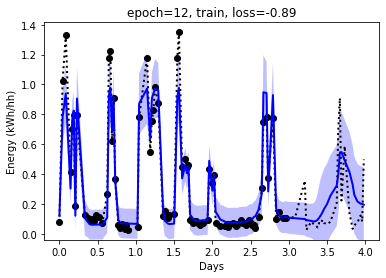

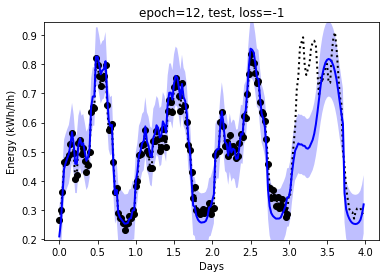

epoch: 12, loss: -1.089, loss_test:-1.02, kl= 0, grad_norm:  1.3


13, i=0, loss: -1.174, test: -1.034, grad_norm:  0.59, std:  0.1
13, i=100, loss: -0.9832, test: -1.04, grad_norm:  1, std:  0.12
13, i=200, loss: -1.081, test: -0.9649, grad_norm:  1.5, std:  0.11
13, i=300, loss: -1.104, test: -1.095, grad_norm:  0.86, std:  0.11
13, i=400, loss: -0.8859, test: -0.9841, grad_norm:  1.9, std:  0.12
13, i=500, loss: -1.112, test: -1.007, grad_norm:  0.6, std:  0.11
13, i=600, loss: -1.103, test: -1.007, grad_norm:  0.61, std:  0.11
13, i=700, loss: -1.126, test: -1.028, grad_norm:  0.7, std:  0.1
13, i=800, loss: -1.102, test: -1.05, grad_norm:  0.69, std:  0.11
13, i=900, loss: -0.7621, test: -0.9737, grad_norm:  1.4, std:  0.14
13, i=1000, loss: -1.02, test: -0.9908, grad_norm:  1.4, std:  0.12


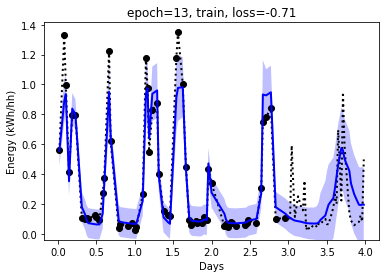

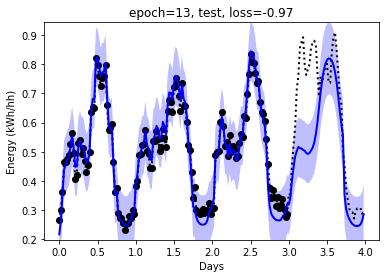

epoch: 13, loss: -1.036, loss_test:-0.9741, kl= 0, grad_norm:  0.93


14, i=0, loss: -0.9577, test: -0.9686, grad_norm:  1.3, std:  0.12
14, i=100, loss: -1.133, test: -0.9806, grad_norm:  0.52, std:  0.11
14, i=200, loss: -1.061, test: -0.9122, grad_norm:  0.93, std:  0.11
14, i=300, loss: -0.7354, test: -1.059, grad_norm:  1.4, std:  0.14
14, i=400, loss: -1.095, test: -1.08, grad_norm:  1.1, std:  0.11
14, i=500, loss: -1.083, test: -1.073, grad_norm:  1.7, std:  0.11
14, i=600, loss: -1.048, test: -1.007, grad_norm:  1.8, std:  0.11
14, i=700, loss: -1.037, test: -1.06, grad_norm:  0.57, std:  0.11
14, i=800, loss: -1.182, test: -1.015, grad_norm:  1.3, std:  0.11
14, i=900, loss: -0.9658, test: -0.9943, grad_norm:  1, std:  0.12
14, i=1000, loss: -1.168, test: -0.9937, grad_norm:  0.48, std:  0.11


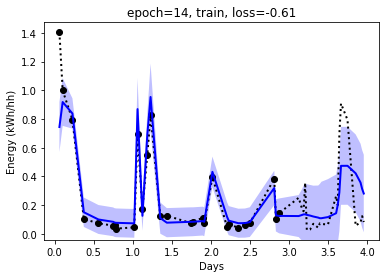

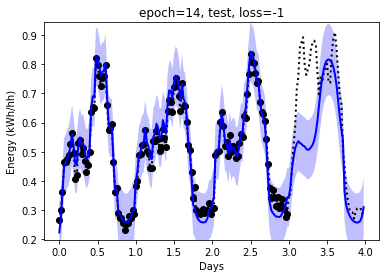

epoch: 14, loss: -0.9603, loss_test:-1.008, kl= 0, grad_norm:  1.3


15, i=0, loss: -1.126, test: -1.02, grad_norm:  0.93, std:  0.11
15, i=100, loss: -1.091, test: -1.007, grad_norm:  1, std:  0.11
15, i=200, loss: -1.091, test: -1.007, grad_norm:  1.4, std:  0.11
15, i=300, loss: -1.115, test: -1.015, grad_norm:  0.55, std:  0.11
15, i=400, loss: -0.9114, test: -1.053, grad_norm:  1.7, std:  0.12
15, i=500, loss: -1.166, test: -1.024, grad_norm:  1.3, std:  0.11
15, i=600, loss: -1.179, test: -1.042, grad_norm:  0.81, std:  0.11
15, i=700, loss: -1.056, test: -0.968, grad_norm:  1, std:  0.11
15, i=800, loss: -1.134, test: -1.022, grad_norm:  0.53, std:  0.11
15, i=900, loss: -0.9884, test: -0.9555, grad_norm:  1, std:  0.12
15, i=1000, loss: -1.084, test: -1.015, grad_norm:  1.3, std:  0.11


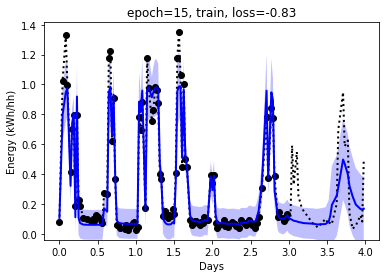

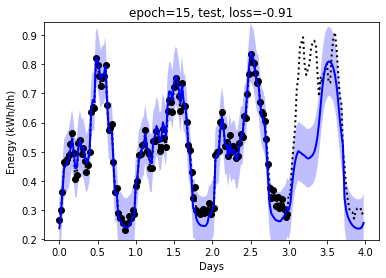

epoch: 15, loss: -1.018, loss_test:-0.9129, kl= 0, grad_norm:  0.93


16, i=0, loss: -1.085, test: -0.9059, grad_norm:  2, std:  0.11
16, i=100, loss: -1.145, test: -0.9844, grad_norm:  0.83, std:  0.11
16, i=200, loss: -1.127, test: -0.9862, grad_norm:  0.49, std:  0.11
16, i=300, loss: -1.139, test: -1.032, grad_norm:  1.1, std:  0.11
16, i=400, loss: -0.9772, test: -1.079, grad_norm:  1, std:  0.12
16, i=500, loss: -1.032, test: -1.077, grad_norm:  1.6, std:  0.12
16, i=600, loss: -1.138, test: -1.017, grad_norm:  0.51, std:  0.11
16, i=700, loss: -1.134, test: -0.9981, grad_norm:  0.63, std:  0.11
16, i=800, loss: -1.031, test: -1.004, grad_norm:  0.6, std:  0.12
16, i=900, loss: -1.108, test: -0.9762, grad_norm:  0.52, std:  0.11
16, i=1000, loss: -1.058, test: -1.018, grad_norm:  0.88, std:  0.11


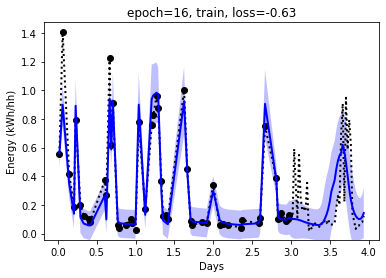

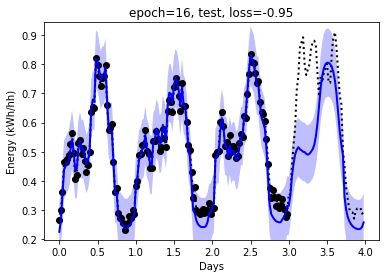

epoch: 16, loss: -1.055, loss_test:-0.9482, kl= 0, grad_norm:  1


17, i=0, loss: -1.147, test: -0.9401, grad_norm:  0.69, std:  0.11
17, i=100, loss: -1.181, test: -1.025, grad_norm:  1.2, std:  0.11
17, i=200, loss: -1.051, test: -1.043, grad_norm:  0.99, std:  0.11
17, i=300, loss: -1.178, test: -0.9912, grad_norm:  0.67, std:  0.1
17, i=400, loss: -1.13, test: -1.014, grad_norm:  0.87, std:  0.11
17, i=500, loss: -1.177, test: -0.9989, grad_norm:  0.74, std:  0.1
17, i=600, loss: -1.058, test: -1.004, grad_norm:  0.76, std:  0.11
17, i=700, loss: -1.136, test: -1.007, grad_norm:  1, std:  0.11
17, i=800, loss: -1.206, test: -1.031, grad_norm:  0.42, std:  0.11
17, i=900, loss: -1.203, test: -1.004, grad_norm:  0.54, std:  0.1
17, i=1000, loss: -1.061, test: -1.028, grad_norm:  0.5, std:  0.11


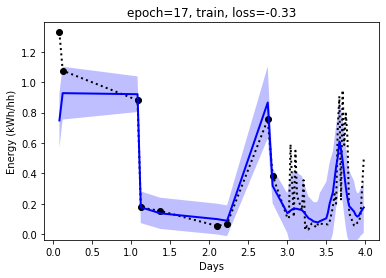

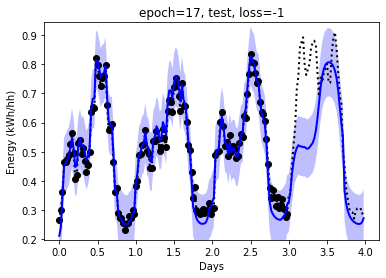

epoch: 17, loss: -0.9645, loss_test:-1.009, kl= 0, grad_norm:  1.7


18, i=0, loss: -1.137, test: -1.01, grad_norm:  1.2, std:  0.11
18, i=100, loss: -1.217, test: -1.038, grad_norm:  0.99, std:  0.1
18, i=200, loss: -1.063, test: -1.102, grad_norm:  0.68, std:  0.11
18, i=300, loss: -1.176, test: -1.01, grad_norm:  1.2, std:  0.11
18, i=400, loss: -1.133, test: -1.002, grad_norm:  0.7, std:  0.11
18, i=500, loss: -1.083, test: -0.9935, grad_norm:  0.95, std:  0.11
18, i=600, loss: -0.6473, test: -0.9872, grad_norm:  2, std:  0.14
18, i=700, loss: -0.8489, test: -1.032, grad_norm:  1.4, std:  0.13
18, i=800, loss: -0.8665, test: -1.037, grad_norm:  1.6, std:  0.13
18, i=900, loss: -1.037, test: -1.057, grad_norm:  1.7, std:  0.11
18, i=1000, loss: -1.053, test: -1.006, grad_norm:  0.69, std:  0.11


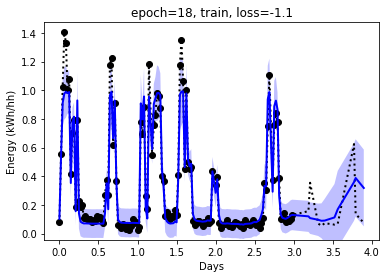

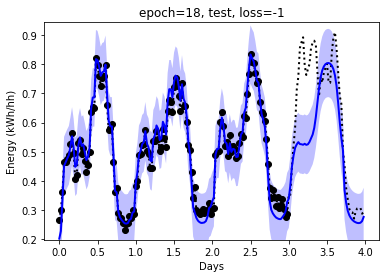

epoch: 18, loss: -1.116, loss_test:-1.043, kl= 0, grad_norm:  3.9


19, i=0, loss: -1.225, test: -1.054, grad_norm:  1.1, std:  0.1
19, i=100, loss: -1.166, test: -1.036, grad_norm:  1.3, std:  0.1
19, i=200, loss: -1.178, test: -1.05, grad_norm:  0.47, std:  0.11
19, i=300, loss: -1.06, test: -1.019, grad_norm:  0.94, std:  0.11
19, i=400, loss: -0.7998, test: -1.026, grad_norm:  1.6, std:  0.12
19, i=500, loss: -1.094, test: -1.02, grad_norm:  2.1, std:  0.11
19, i=600, loss: -1.141, test: -1.017, grad_norm:  0.72, std:  0.11
19, i=700, loss: -0.757, test: -1.001, grad_norm:  1.6, std:  0.13
19, i=800, loss: -1.063, test: -1.007, grad_norm:  1.3, std:  0.11
19, i=900, loss: -1.091, test: -1.027, grad_norm:  1.1, std:  0.11
19, i=1000, loss: -1.213, test: -1.024, grad_norm:  0.66, std:  0.1


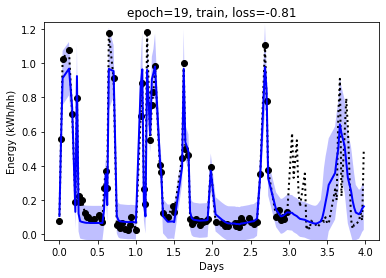

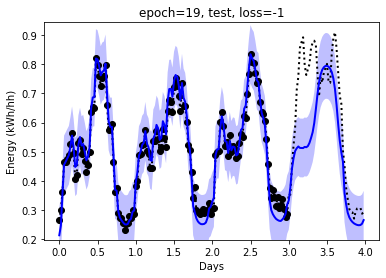

epoch: 19, loss: -1.099, loss_test:-1.016, kl= 0, grad_norm:  1.3



In [25]:
epochs = 20
grad_clip = 10
history = []
for epoch in tqdm(range(epochs), unit='epoch'):

    pbar = tqdm(loader_train, unit='batch')
    for i, data in enumerate(pbar):
        model.train()
        assert all(torch.isfinite(d).all() for d in data)
        data = [d.to(device) for d in data]
        context_x, context_y, target_x, target_y = data

        optim.zero_grad()
        y_pred, kl, loss, y_std = model(context_x, context_y, target_x, target_y)

        # These attentive NP models work great when you need uncertainty, but still seem a bit unstable. 
        # Sometimes they produce nans, especically if the data is not fully normalized. 
        assert torch.isfinite(y_pred.sum())
        if not torch.isfinite(loss):
            logger.error("loss is not finite")
            continue
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        if not np.isfinite(grad_norm):
            logger.error("grad_norm is not finite")
            continue
        optim.step()

        if i%100==0:
            model.eval()
            test_loss = plot_from_loader(loader_test, i=vis_i, plot=False)
            pbar.set_description(f"{epoch}, loss: {loss.item():4.4g}, test: {test_loss.item():4.4g}")
            print(f"{epoch}, i={i}, loss: {loss.item():4.4g}, test: {test_loss.item():4.4g}, grad_norm: {grad_norm: 2.2g}, std: {y_std.mean().item(): 2.2g}")
            
            history.append(dict(
                n=epoch*len(loader_train) + i,
                epoch=epoch,
                i=i,
                loss=loss.item(),
                kl=kl.mean().item(),
                test_loss=test_loss.item(),
                y_std=y_std.mean().item(),
                grad_norm=grad_norm,
            ))
        
    test_loss = plot_from_loader(loader_train, i=vis_i, title=f'epoch={epoch}, train,')
    model.eval()
    test_loss = plot_from_loader(loader_test, i=vis_i, title=f'epoch={epoch}, test,')
    print(f"epoch: {epoch}, loss: {loss.item():4.4g}, loss_test:{test_loss.item():4.4g}, kl={kl.mean().item():2.2g}, grad_norm: {grad_norm: 2.2g}")

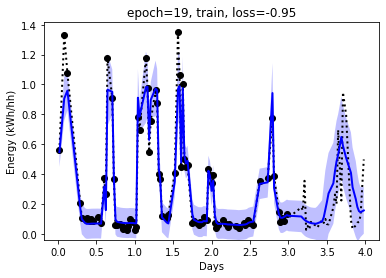

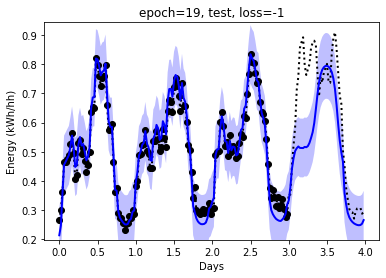

In [26]:
test_loss = plot_from_loader(loader_train, i=vis_i, title=f'epoch={epoch}, train,')
model.eval()
test_loss = plot_from_loader(loader_test, i=vis_i, title=f'epoch={epoch}, test,')

## History

In [27]:
df_hist = pd.DataFrame(history)
df_hist['n'] = df_hist['epoch'] * len(loader_train) + df_hist['i']
df_hist = df_hist.set_index('n')
df_hist.head(3)

,epoch,grad_norm,i,kl,loss,test_loss,y_std
n,,,,,,,
0,0,146.899936,0,0.0,25.704908,33.517654,0.069054
100,0,2.665281,100,0.0,0.962494,0.111815,0.102052
200,0,1.021446,200,0.0,-0.019354,-0.285843,0.154730


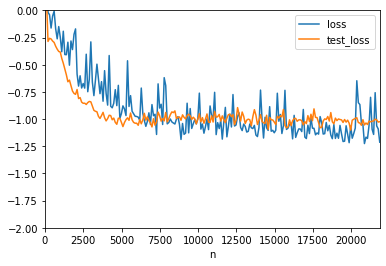

In [28]:
(df_hist[['loss', 'test_loss']]).plot(ylim=[-2,0])

/home/wassname/.pyenv/versions/3.7.2/envs/jup3.7.2/lib/python3.7/site-packages/pandas/plotting/_core.py:441: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(self.ylim)


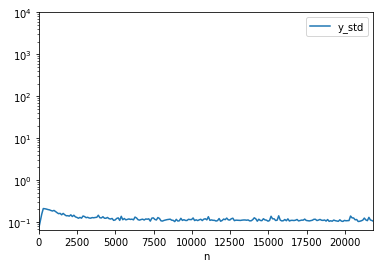

In [29]:
df_hist[['y_std']].plot(ylim=[0,1e4], logy=True)

In [30]:
df_hist[100:]

,epoch,grad_norm,i,kl,loss,test_loss,y_std
n,,,,,,,
9982,9,1.176187,100,0.0,-0.995843,-1.001332,0.114483
10082,9,1.523944,200,0.0,-0.761233,-0.951071,0.125141
10182,9,1.331562,300,0.0,-1.092294,-1.024931,0.108563
10282,9,0.824678,400,0.0,-1.045715,-0.986368,0.113150
10382,9,0.586848,500,0.0,-1.129983,-1.038755,0.108336
10482,9,0.647051,600,0.0,-1.068789,-0.999462,0.112882
10582,9,1.023849,700,0.0,-0.997582,-0.952856,0.116589
10682,9,0.648039,800,0.0,-1.097068,-1.029012,0.108470
10782,9,1.388159,900,0.0,-0.879391,-1.030401,0.117170


In [31]:
len(loader_test)

117